In [70]:
import numpy as np
import random
from itertools import product
import matplotlib.pyplot as plt

# GridWorld Problem
### Step 1: Environment

In [75]:
class GridWorld:
    def __init__(self, n, blocks, bomb, gold, init_state, unreliability = 0.2):
        self.n = n # grid size (n x n)
        self.blocks = blocks # block position (unpassable)
        self.bomb = bomb # bomb position (terminal bad state)
        self.gold = gold # gold position (terminal good state)
        self.state = init_state # initial state
        self.state_init = init_state # initial state
        self.terminal = False
        self.unreliability = unreliability

    def reset(self):
        self.state = (0,0)
        self.terminal = False
        return self.state
    
    def step(self, ori_action, state = None):
        if state == None:
            state = self.state

        if self.terminal:
            return self.state, 0, True # returns state, reward, terminate or not
        
        if random.random() < self.unreliability:
            action = random.choice([0,1,2,3]) # up, down, left, right
        else:
            action = ori_action

        if action == 0: # up
            next_state = (max(state[0] - 1, 0), state[1])
        elif action == 1: # down
            next_state = (min(state[0] + 1, self.n - 1), state[1])
        elif action == 2: # left
            next_state = (state[0], max(state[1] - 1, 0))
        elif action == 3: # right
            next_state = (state[0], min(state[1] + 1, self.n - 1))

        if next_state in self.blocks:
            next_state = self.state

        self.state = next_state

        # check terminal states
        if self.state == self.bomb:
            self.terminal = True
            return self.state, -100, True
        elif self.state == self.gold:
            self.terminal = True
            return self.state, 100, True
        return self.state, -1, False
    
    def plot_policy(self, q):
        n = q.shape[0]
        fig, ax = plt.subplots(figsize=(n, n))
        for i, j in product(range(self.n), repeat = 2):
            if (i, j) not in [self.bomb, self.gold] + self.blocks:
                ax.arrow(j + 0.5, n - i - 0.5, *[(0, 0.2), (0, -0.2), (-0.2, 0), (0.2, 0)][q[i, j]], head_width=0.1)
        
        for position, color, label in [(self.state_init, 'b', 'start'), (self.bomb, 'r', 'bomb'), (self.gold, 'y', 'gold')]:
            ax.add_patch(plt.Circle((position[1] + 0.5, n - position[0] - 0.5), 0.2, color=color, label=label))
        
        for x in self.blocks:
            ax.add_patch(plt.Rectangle((x[1], n - x[0] - 1), 1, 1, color='gray', alpha=0.5, label='block' if x == self.blocks[0] else ''))

        ax.set(xlim=(0, n), ylim=(0, n), xticks=range(n), yticks=range(n), xticklabels=range(n), yticklabels=range(n)[::-1])
        ax.grid(True)
        ax.legend(ncol=4, bbox_to_anchor=(0.5, -0.1), loc='upper center')
        plt.show()

### Step 2: MDP Solution (Value Iteration)

In [76]:
class MDP:
    def __init__(self, grid_world, discount = 0.9, theta = 1e-6): # environment, discount_rate, converge_threshold
        self.env = grid_world
        self.discount = discount
        self.theta = theta
        self.n = grid_world.n
        self.values = np.zeros((self.n, self.n))
        self.policy = np.zeros((self.n, self.n), dtype = int)

    def simulate(self, state, action):
        next_state, reward, done = self.env.step(action, state)
        self.env.reset()
        return next_state, reward, done

    def value_iteration(self):
        while True: 
            delta = 0 
            for i, j in product(range(self.n), repeat=2): 
                state = (i, j)
                if state in [self.env.bomb, self.env.gold]:
                    continue

                # Store action values in a list to avoid repeated calls
                action_values = []
                for action in range(4):
                    next_state, reward, _ = self.simulate(state, action)
                    action_value = reward + self.discount * self.values[next_state[0], next_state[1]]
                    action_values.append(action_value)

                # Best action value for the current state
                best_value = max(action_values)
                best_action = np.argmax(action_values)

                # Update the value function and policy
                delta = max(delta, abs(self.values[i, j] - best_value))
                self.values[i, j] = best_value
                self.policy[i, j] = best_action

            # Check for convergence
            if delta < self.theta:
                break



### Step 3: Q-learning Solution

In [77]:
class QLearning:
    def __init__(self, grid_world, alpha = 0.01, gamma = 0.9, epsilon = 0.2, episodes = 1000):
        self.env = grid_world
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor -> when tuning, keep this high 0.99, and play around with other parameters
        self.epsilon = epsilon # exploration rate
        self.episodes = episodes
        self.q_table = np.zeros((self.env.n, self.env.n, 4)) # q-values for each state-action

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3) 
        else:
            return np.argmax(self.q_table[state[0], state[1]])
        
    def learn(self):
        for episode in range(self.episodes):
            state = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                best_next_action = np.argmax(self.q_table[next_state[0], next_state[1]])
                self.q_table[state[0], state[1], action] += self.alpha * (
                    reward 
                    + self.gamma * self.q_table[next_state[0], next_state[1], best_next_action]
                    - self.q_table[state[0], state[1], action])
                state = next_state


### Step 4: Run Comparison

Optimal Policy (MDP):


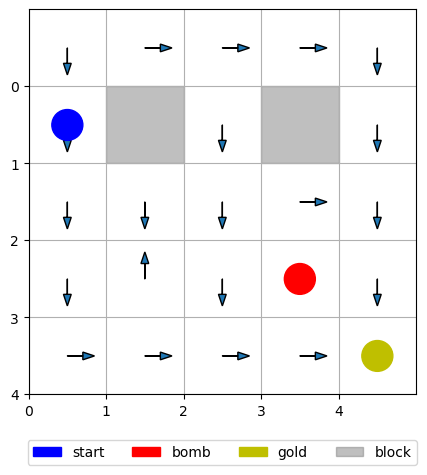

Optimal Policy (Q-learning):


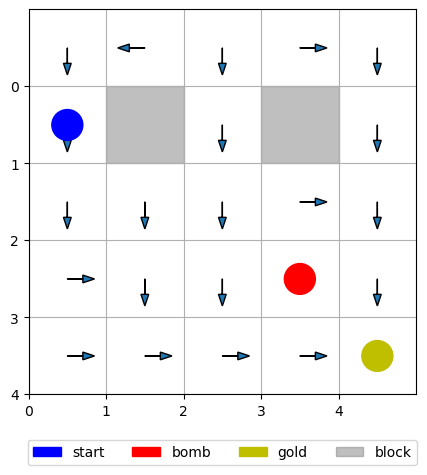

In [78]:
grid_world = GridWorld(n = 5, init_state = (1,0), blocks = [(1,1), (1,3)], bomb = (3,3), gold = (4,4))

# MDP
mdp_solver = MDP(grid_world)
mdp_solver.value_iteration()
print("Optimal Policy (MDP):")
policy = mdp_solver.policy
grid_world.plot_policy(policy)

# Q-learning
q_learning_solver = QLearning(grid_world)
q_learning_solver.learn()
policy = np.argmax(q_learning_solver.q_table, axis=2)
print("Optimal Policy (Q-learning):")
grid_world.plot_policy(policy)

